## Imports

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import time
import seaborn as sns
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

sys.path.append('../src')
from utils import plot_spectrum

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(f"device {device}")

True
device cuda


# Data preparation
* Variance thresholding
* Normalization so that the mean is 0 and variance is 1

### Load data and split them into features X and target y

In [20]:
start = time.time()

X = []
y = []

data_dir = '../data'
filenames = glob.glob(os.path.join(data_dir, '*.pth'))
metadata = pd.DataFrame(list(map(lambda a: a[15:-4].split('_'), filenames)),
                        columns=['system', 'annotator_ID', 'measurement_number', 'compound'])

for i, filename in enumerate(filenames):
    spectrum = torch.load(filename).numpy().flatten()
    label = metadata.iloc[i]['compound']
    X.append(spectrum)
    y.append(label)
X = np.array(X)
y = np.array(y)
print(f"Data loaded in {(time.time() - start):.1f} seconds.")

Data loaded in 9.3 seconds.


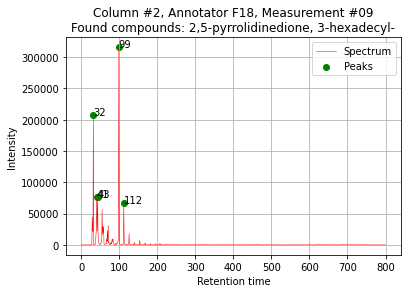

In [21]:
%matplotlib inline
plot_spectrum(X[0], metadata.iloc[0])

### Variance thresholding

In [33]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=1e-6)
X = selector.fit_transform(X)
# selector.fit_transform(X).shape

### l2 normalization

In [22]:
from sklearn import preprocessing
X = preprocessing.normalize(X, norm='l2')

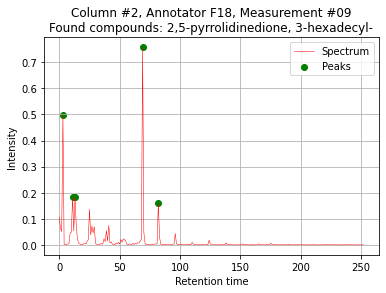

In [34]:
plot_spectrum(X[0], metadata.iloc[0])

### Split into training and testing data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling + Training

In [36]:
from sklearn.neighbors import KNeighborsClassifier

start = time.time()
knn = KNeighborsClassifier(n_neighbors=1,
                           n_jobs=-1)
knn.fit(X_train, y_train)
print(f"Prediction done in {(time.time() - start):.1f} seconds.")

Prediction done in 0.0 seconds.


# Evaluation
*metrics - accuracy, precision, recall, f1 - score

In [37]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83


# Fine-tuning hyperparameters
* Cross-validation

### 5-fold Cross-Validation

In [50]:
start = time.time()
score = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
print(score)
print(f"Cross-validation done in {(time.time() - start):.1f} seconds.")

start = time.time()
score = cross_val_score(knn, X, y, cv=5, n_jobs=-1, scoring='accuracy')
print(score)
print(f"Cross-validation done in {(time.time() - start):.1f} seconds.")

[0.81135297 0.81327358 0.79534784 0.81113956 0.81007256]
Cross-validation done in 24.8 seconds.
[0.81135297 0.81327358 0.79534784 0.81113956 0.81007256]
Cross-validation done in 15.8 seconds.


In [38]:
from tqdm import tqdm

k_values = [i for i in range (1, 32, 2)]
scores = []
with tqdm(k_values, unit="k-value") as tk_value:
    for k in tk_value:
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        score = cross_val_score(knn, X, y, cv=5, n_jobs=-1, scoring='accuracy')
        mean_score = np.mean(score)
        scores.append(mean_score)
        tk_value.set_postfix(mean_accuracy = 100. * mean_score.item())


best_index = np.argmax(scores)
best_k = k_values[best_index]


100%|██████████| 16/16 [03:07<00:00, 11.70s/k-value, mean_accuracy=74.4]


Text(0.5, 1.0, '5-fold Cross-Validation - best k = 1')

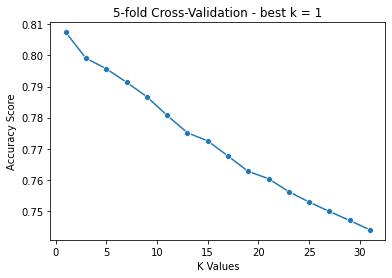

In [39]:
%matplotlib inline
sns.lineplot(x=k_values, y=scores, marker='o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.title(f"5-fold Cross-Validation - best k = {best_k}")

In [53]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81
